# MNIST Basics: Neural Networks from Scratch #

In this notebook, we will explore the fundamentals of neural networks by working with the MNIST dataset of handwritten digits. We'll start by visualising the data, then build a simple classifier from scratch — no high-level models yet! Along the way, we’ll learn how to represent images as tensors, compute distances, and gradually move toward a basic neural network to recognize 3s and 7s.

In [2]:
from fastai.vision.all import *
from fastbook import *

/opt/anaconda3/envs/fastai_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/fastai_env/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/anaconda3/envs/fastai_env/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <C62FA868-4C49-3B20-AFA6-2F7F59A295B4> /opt/anaconda3/envs/fastai_env/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


For this initial tutorial we are just going to try to create a model that can classify any image as a 3 or a 7. 

### Download Sample of MNIST ###

So let's download a sample of MNIST that contains images of just these digits:

- URLs is a FastAI class that contains links to commonly used datasets.
- untar_data( ) is a FastAI utility function that:
    1. Downloads the dataset from the URL
    2. Extracts it (hence 'untar') and returns a Path object pointing to the local folder where the data is stored.

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

Set the default folder for all file paths in this notebook to be the MNIST sample dataset folder, so I don’t have to type the full path every time.

In [4]:
#hide

# Set the default base folder for all Path objects in this notebook
# This means that later, when we refer to files with relative paths,
# FastAI will look inside the MNIST_SAMPLE folder automatically

Path.BASE_PATH = path

Next we want to take a look in the folder.

ls( ) lists everything in this folder.  However with FastAI, instead of returning a list, it returns an L object.  It acts as a normal list that can be looped, indexed over but also, when you print it, it tells you how many things are in the folder.

In [5]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation set (and/or test set). Let's see what's inside the training set:

In [6]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

There's a folder of 3s, and a folder of 7s. In machine learning parlance, we say that "3" and "7" are the labels (or targets) in this dataset. 

Let's take a look in one of these folders (using sorted to ensure we all get the same order of files):

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png'),Path('train/3/10093.png'),Path('train/3/10097.png'),Path('train/3/10099.png'),Path('train/3/10116.png'),Path('train/3/10125.png'),Path('train/3/10137.png'),Path('train/3/10141.png'),Path('train/3/10144.png'),Path('train/3/10155.png'),Path('train/3/10161.png')...]

As we might expect, it's full of image files. Let’s take a look at one now. Here’s an image of a handwritten number 3, taken from the famous MNIST dataset of handwritten numbers:

In [8]:
# Select the second image file path from the list of '3' images
im3_path = threes[1]

# Open the image at that path using PIL (Python Imaging Library)
im3 = Image.open(im3_path)

# Display the image in the notebook
im3


In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a NumPy array or a PyTorch tensor. For instance, here's what a section of the image looks like, converted to a NumPy array:

In [9]:
# Convert the image `im3` to a NumPy array and extract a small 6x6 patch
# from rows 4 to 9 and columns 4 to 9 (Python slicing excludes the end index)
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

Here's the same thing as a PyTorch tensor:

In [10]:
# Convert the image `im3` to a PyTorch tensor and extract a small 6x6 patch
# from rows 4 to 9 and columns 4 to 9 (Python slicing excludes the end index)
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values

In [11]:
#hide_output
# Convert the image `im3` to a PyTorch tensor
im3_t = tensor(im3)

# Take a subregion of the tensor (rows 4 to 14, columns 4 to 21)
# and convert it into a pandas DataFrame for easier visualization
df = pd.DataFrame(im3_t[4:15, 4:22])

# Style the DataFrame: set the font size very small and apply a grey color gradient
# to visually represent the pixel intensity values
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


Here we convert a portion of the image to a DataFrame to better visualize the pixel values.
Darker cells correspond to higher pixel intensity, giving us a clear numeric view of the image region.

So, now we have seen what an image looks like to a computer, let's recall our goal: create a model that can recognize 3s and 7s. 

**How might you go about getting a computer to do that?**

Warning: Stop and Think!: Before you read on, take a moment to think about how a computer might be able to recognize these two different digits.

*Visual differences*

- What shapes or strokes make a 3 different from a 7?
- Look at the curves and lines — which digit has a full curve at the bottom? Which has a straight diagonal line?
  
*Pixel-level clues*

- If a computer looks at the image as a grid of pixels, which pixels might change the most between a 3 and a 7?
- Look at edges and corners — the pixels that form the top bar of a 7, or the loops in a 3, will stand out.
  
*Feature representation*

- How could a computer summarize these differences into simple features (like “curved vs straight”)?
- It could compute averages of pixel intensities, detect lines or curves, or even measure distances to prototype images.
  
*Combining features*

- Once the computer knows several features, how could it combine them to make a prediction?
- It could assign weights to each feature and compute a score, choosing the digit whose features match best.

*Generalisation*

- How would the computer handle handwriting that’s messy or different from training examples?
- The computer needs to learn patterns, not just exact pixels. That’s why neural networks learn flexible representations instead of memorizing images.

## Pixel Similarity ##

How about we find the average pixel value for every pixel of the 3s, then do the same for the 7s? This will give us two group averages, defining what we might call the "ideal" 3 and 7. Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to. This certainly seems like it should be better than nothing, so it will make a good baseline.

**How Do We Do This?**

Step one for our simple model is to get the average of pixel values for each of our two groups. 

Let's create a tensor containing all of our 3s stacked together. We already know how to create a tensor containing a single image. To create a tensor containing all the images in a directory, we will first use a Python list comprehension to create a plain list of the single image tensors.

Here we load all the training images for digits 3 and 7 and convert them into tensors, preparing the data so it can be used in numerical computations and later fed into a model.

In [12]:
# Open each image file for the digit 7 and convert it into a PyTorch tensor
seven_tensors = [tensor(Image.open(o)) for o in sevens]

# Open each image file for the digit 3 and convert it into a PyTorch tensor
three_tensors = [tensor(Image.open(o)) for o in threes]

# Check how many tensor images we have for each digit
len(three_tensors),len(seven_tensors)

(6131, 6265)

We'll also check that one of the images looks okay. Since we now have tensors (which Jupyter by default will print as values), rather than PIL images (which Jupyter by default will display as images), we need to use fastai's show_image function to display it.

This lets us visually confirm that the tensor data has been loaded correctly by displaying one example of the digit 3.

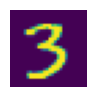

In [13]:
# Display the second image tensor for the digit 3 to visually inspect the data
show_image(three_tensors[1]);

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. To do this we first combine all the images in this list into a single three-dimensional tensor. The most common way to describe such a tensor is to call it a rank-3 tensor. We often need to stack up individual tensors in a collection into a single tensor. Unsurprisingly, PyTorch comes with a function called stack that we can use for this purpose.

In ELI5 terms:  

You have a big stack of handwritten 3s on paper. Every page is:

- the same size
- made of tiny squares (pixels)
- each square has a darkness value (how much ink is there?)

Now you ask:

“If I look at the top-left square across all the pages, how dark is it on average?”

Then you ask the same question for:

- the next square
- and the next
- and the next…

Until you’ve done it for every pixel position.

In [14]:
# Stack all the 7 image tensors into a single 3D tensor
# Shape: (number_of_images, height, width)
# Convert values to floats and scale pixel intensities from 0–255 to 0–1
stacked_sevens = torch.stack(seven_tensors).float() / 255

# Do the same for all the 3 image tensors
stacked_threes = torch.stack(three_tensors).float() / 255

# Check the shape of the stacked tensor to confirm how the data is organized
stacked_threes.shape


torch.Size([6131, 28, 28])